#### Importing libs and instanciating SC and SQLSC

In [1]:
# useful libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# pyspark libs
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession, Row, Window
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.mllib.feature import StandardScaler, Normalizer, HashingTF, IDF
from pyspark.mllib.linalg import Vectors, SparseVector, DenseMatrix
from pyspark.mllib.stat import Statistics

from pyspark.ml.feature import StringIndexer, VectorIndexer, Imputer, MinMaxScaler, VectorAssembler, OneHotEncoder, QuantileDiscretizer, Bucketizer, ChiSqSelector
from pyspark.ml.stat import Correlation

#### Loading the dataframe

In [2]:
ss = SparkSession.builder.appName("data_understanding").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/14 20:36:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read the CSV file with multiline values (description and facilities)
data = ss.read.options(header = True, inferSchema = True, multiline = True, escape = "\"").csv("dataframe_eda.csv")

# dataframe's dimension and attributes
print(f"Size of the dataframe:\n{data.count(), len(data.columns)}")
print()
print(f"Columns names:\n{data.columns}")
print()
print(f"Columns and types:\n{data.dtypes}")

Size of the dataframe:
(75616, 28)

Columns names:
['regio1', 'heatingType', 'balcony', 'picturecount', 'yearConstructed', 'firingTypes', 'hasKitchen', 'cellar', 'condition', 'interiorQual', 'petsAllowed', 'streetPlain', 'lift', 'typeOfFlat', 'geo_plz', 'noRooms', 'floor', 'numberOfFloors', 'garden', 'regio2', 'regio3', 'description', 'facilities', 'serviceCharge', 'totalRent', 'baseRent', 'livingSpace', 'thermalChar']

Columns and types:
[('regio1', 'string'), ('heatingType', 'string'), ('balcony', 'boolean'), ('picturecount', 'int'), ('yearConstructed', 'int'), ('firingTypes', 'string'), ('hasKitchen', 'boolean'), ('cellar', 'boolean'), ('condition', 'string'), ('interiorQual', 'string'), ('petsAllowed', 'string'), ('streetPlain', 'string'), ('lift', 'boolean'), ('typeOfFlat', 'string'), ('geo_plz', 'int'), ('noRooms', 'double'), ('floor', 'double'), ('numberOfFloors', 'double'), ('garden', 'boolean'), ('regio2', 'string'), ('regio3', 'string'), ('description', 'string'), ('facilitie

In [4]:
print(f"Size of the dataframe: {data.count(), len(data.columns)}")

Size of the dataframe: (81088, 28)


In [70]:
def atts_by_type(dataframe):
    textAtts = ["description", "facilities"]
    discrAtts = [c[0] for c in dataframe.dtypes if (c[1] == "int")] + ["noRooms","floor","numberOfFloors"]
    contAtts = [c[0] for c in dataframe.dtypes if (c[1] == "double") and (c[0] not in discrAtts)]
    catAtts = [c[0] for c in dataframe.dtypes if ((c[1] == "string") and (c[0] not in textAtts))]
    boolAtts = [c for c in dataframe.columns if c not in (discrAtts + contAtts + catAtts + textAtts)]
    
    # show the attributes of different types
    print(f"Free text attributes:\n{textAtts}", end = "\n\n")
    print(f"Discrete attributes:\n{discrAtts}", end = "\n\n")
    print(f"Continuous attributes:\n{contAtts}", end = "\n\n")
    print(f"Categorical attributes:\n{catAtts}", end = "\n\n")
    print(f"Boolean attributes:\n{boolAtts}", end = "\n\n")
    
    # return double, string and boolean attributes as lists in this order
    return textAtts, discrAtts, contAtts, catAtts, boolAtts

In [6]:
textAtts, discrAtts, contAtts, catAtts, boolAtts = atts_by_type(data)

Free text attributes:
['description', 'facilities']

Discrete attributes:
['picturecount', 'yearConstructed', 'geo_plz', 'noRooms', 'floor', 'numberOfFloors']

Continuous attributes:
['serviceCharge', 'totalRent', 'baseRent', 'livingSpace', 'thermalChar']

Categorical attributes:
['regio1', 'heatingType', 'firingTypes', 'condition', 'interiorQual', 'petsAllowed', 'streetPlain', 'typeOfFlat', 'regio2', 'regio3']

Boolean attributes:
['balcony', 'hasKitchen', 'cellar', 'lift', 'garden']



# Data Understanding

#### After having cleaned the data with the data_preparation

#### Attributes by type

In [7]:
# showing first 5 rows for each group of attributes (except free text)
print("Categorical Attributes:")
data.select(*catAtts).limit(5).show()
print("Discrete Attributes:")
data.select(*discrAtts).limit(5).show()
print("Continuous Attributes:")
data.select(*contAtts).limit(5).show()
print("Boolean Attributes:")
data.select(*boolAtts).limit(5).show()

Categorical Attributes:


+-------------------+--------------------+----------------+--------------------+------------+-----------+--------------------+-----------+-------------------+-------------+
|             regio1|         heatingType|     firingTypes|           condition|interiorQual|petsAllowed|         streetPlain| typeOfFlat|             regio2|       regio3|
+-------------------+--------------------+----------------+--------------------+------------+-----------+--------------------+-----------+-------------------+-------------+
|Nordrhein_Westfalen|self_contained_ce...|             gas|           well_kept|      normal| negotiable|          Hüttenstr.|  apartment|      Gelsenkirchen|Bulmke_Hüllen|
|            Sachsen|     central_heating|             gas|           well_kept|      normal| negotiable|        Hofer_Straße|  apartment|           Chemnitz|   Sonnenberg|
|          Thüringen|    district_heating|district_heating|first_time_use_af...|      normal| negotiable|           Birkenhof|  apartme

#### Number of zero values

In [8]:
# count of zeroes in numerical attributes
num_zeroes = {}

for att in contAtts + discrAtts:
    nz = data.filter(F.col(att) == 0).count()
    num_zeroes[att] = nz

print("Number of zeroes in numerical attributes:\n")
for att, nz in num_zeroes.items():
    print(f"{att}: {nz} zeroes")

Number of zeroes in numerical attributes:

serviceCharge: 1054 zeroes
totalRent: 140 zeroes
baseRent: 44 zeroes
livingSpace: 25 zeroes
thermalChar: 0 zeroes
picturecount: 2127 zeroes
yearConstructed: 0 zeroes
geo_plz: 0 zeroes
noRooms: 0 zeroes
floor: 17673 zeroes
numberOfFloors: 995 zeroes


##### Not many zeroes except floor (this is probably due to the fact that are apartments placed at ground floor or similar)

In [9]:
data.select("typeOfFlat").filter((F.col("floor") == 0)).distinct().show()

+-------------------+
|         typeOfFlat|
+-------------------+
|raised_ground_floor|
|        roof_storey|
|               loft|
|       ground_floor|
|      half_basement|
|      terraced_flat|
|              other|
|         maisonette|
|          penthouse|
|          apartment|
+-------------------+



## Variables' distribution

In [10]:
def plot_hist(df, cont_att, size = (6,4), bins = 50, color = "royalblue"):
    # only values
    values = df.select(cont_att).toPandas()
    
    plt.figure(figsize = size)
    sns.histplot(values, bins = bins, kde = True, palette = [color])
    plt.title(f"Distribution of {cont_att}")
    plt.xlabel(f"{cont_att}")
    plt.ylabel("Frequency")
    plt.show()

In [11]:
def plot_count(df, cat_att, rot = 0, size = (10,4), palette = "viridis"):
    # only values
    values = df.select(cat_att).toPandas()

    plt.figure(figsize = size)
    ax = sns.countplot(x = cat_att, data = values, palette = palette)
    plt.title(f"Distribution of {cat_att}")
    plt.xlabel(f"{cat_att}")
    plt.ylabel("Count")
    
    # rotate x-axis tick labels vertically
    ax.set_xticklabels(ax.get_xticklabels(), rotation = rot)
    plt.show()

##### Attributes to plot (hist or bar)

In [14]:
atts_hist = contAtts + ["yearConstructed", "picturecount"]
discr_bar = [att for att in discrAtts if att not in atts_hist + ["geo_plz"]]
bool_bar = boolAtts[:]
# find catAtts with uniques <= 20
cat_bar = [att for att in catAtts if data.select(att).distinct().count() <= 20]

print(f"Distributions to plot with Histograms:\n{atts_hist}\n")
print(f"Distributions to plot with Barplots:\n{discr_bar + bool_bar + cat_bar}")

Distributions to plot with Histograms:
['serviceCharge', 'totalRent', 'baseRent', 'livingSpace', 'thermalChar', 'yearConstructed', 'picturecount']

Distributions to plot with Barplots:
['noRooms', 'floor', 'numberOfFloors', 'balcony', 'hasKitchen', 'cellar', 'lift', 'garden', 'regio1', 'heatingType', 'condition', 'interiorQual', 'petsAllowed', 'typeOfFlat']


### Histograms

##### Continuous attributes (and many distinct values)

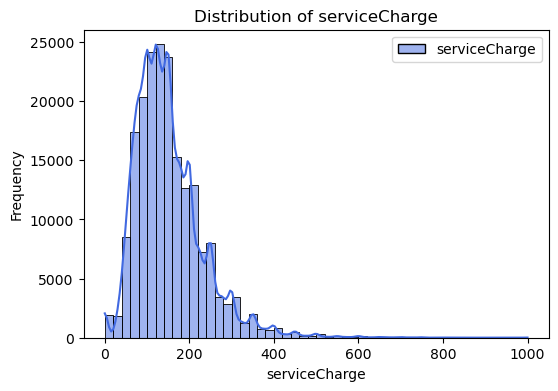

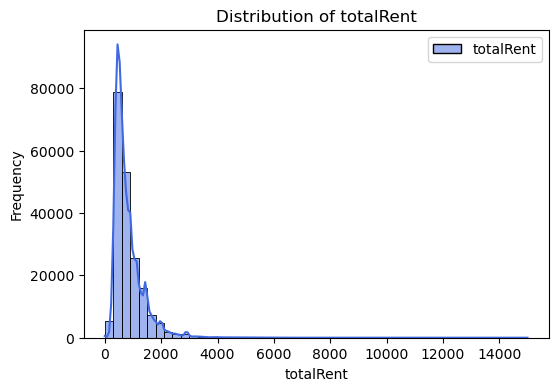

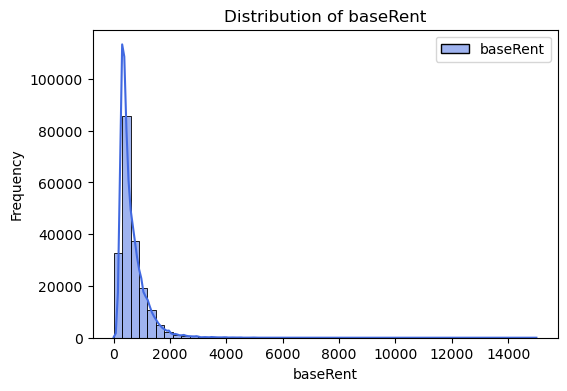

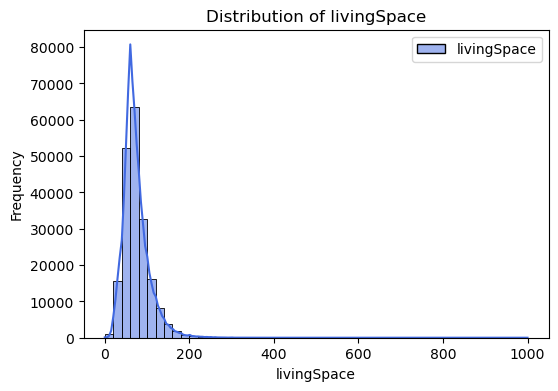

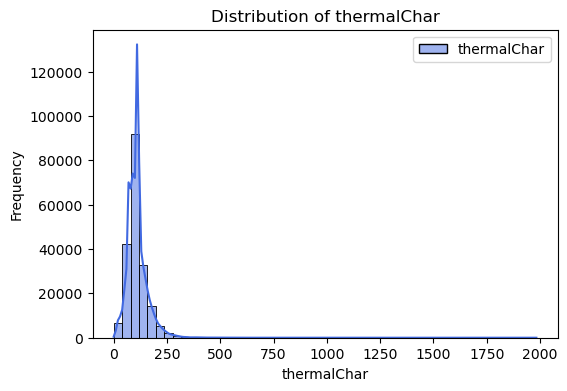

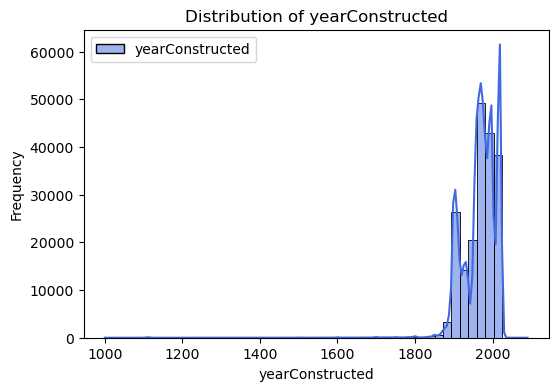

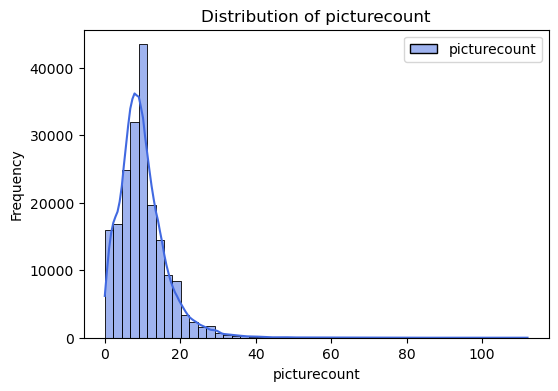

In [15]:
for att in atts_hist:
    plot_hist(data, att, (6,4), 50, "royalblue")

#### Barplots

##### Discrete attributes

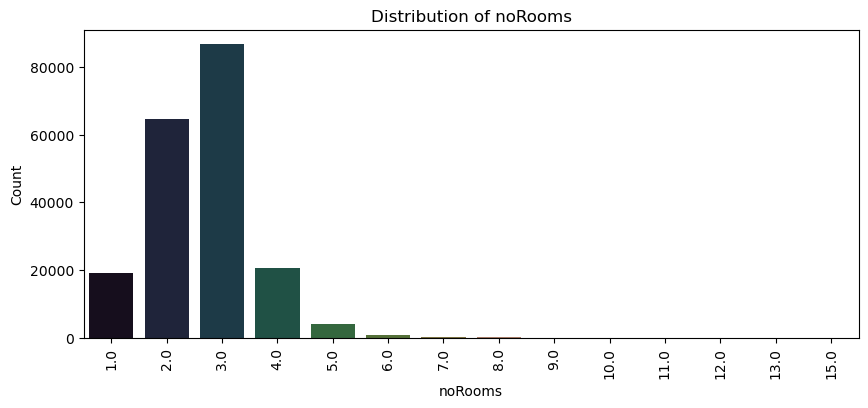

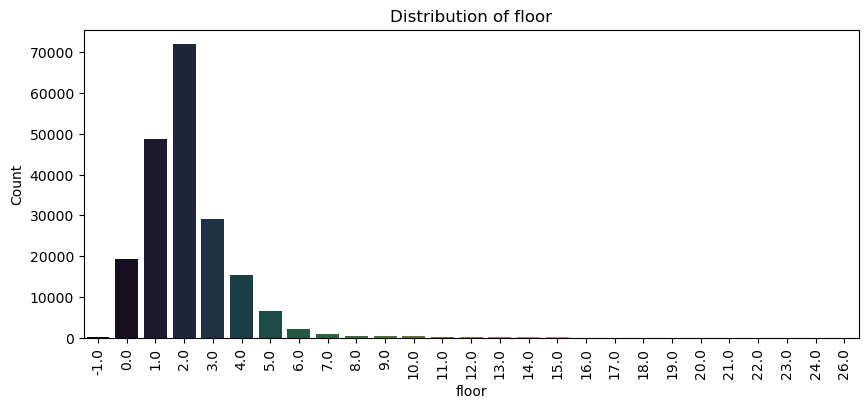

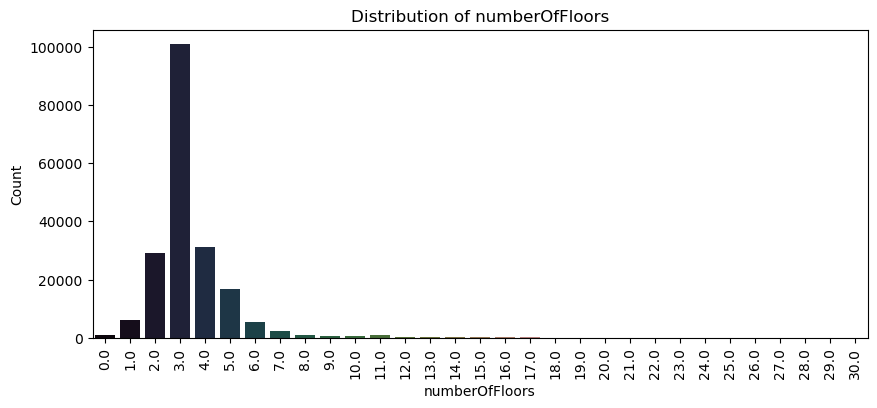

In [16]:
for att in discr_bar:
    plot_count(data, att, 90, (10,4), "cubehelix")

##### Boolean attributes

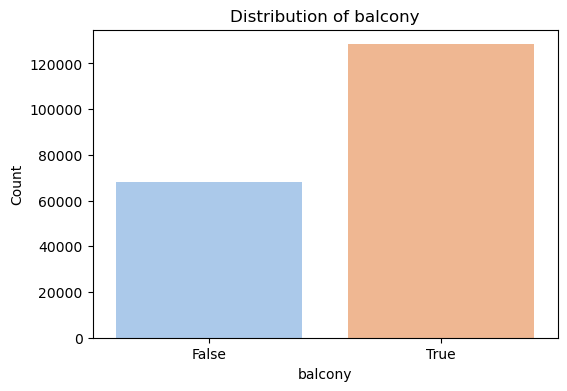

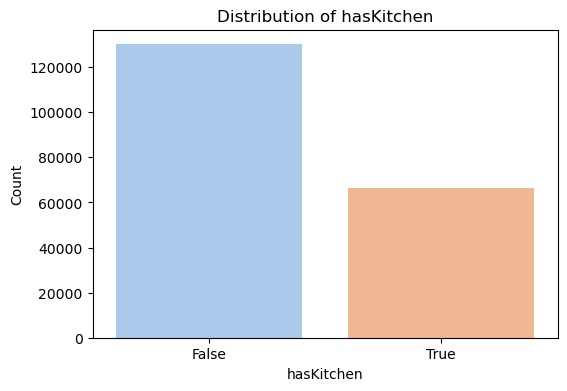

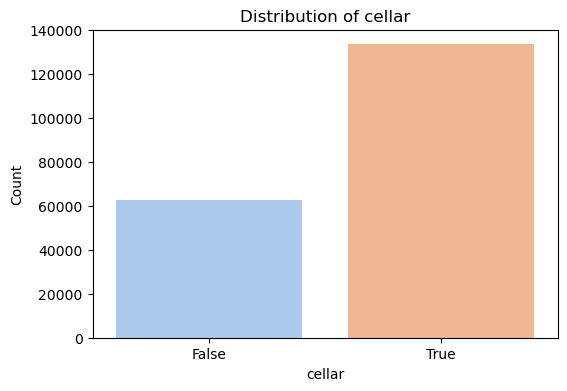

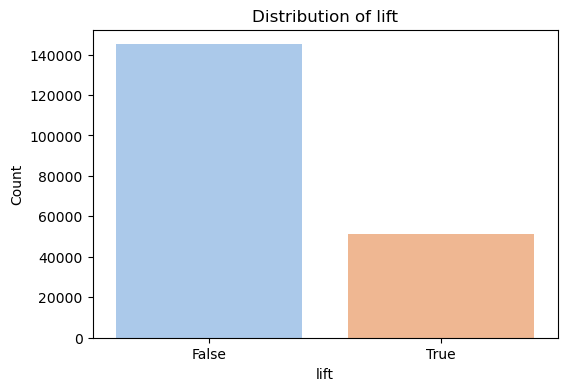

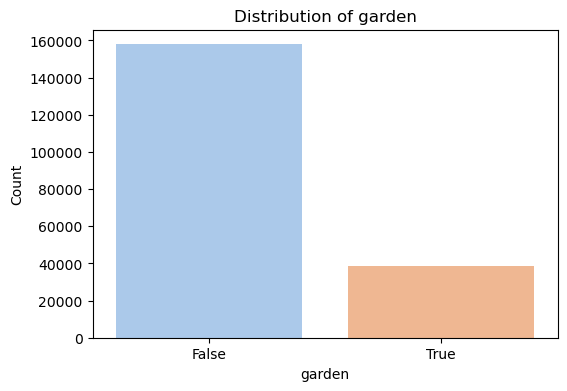

In [17]:
for att in bool_bar:
    plot_count(data, att, 0, (6,4), "pastel")

##### Categorical attributes (only if uniques are less than 20)

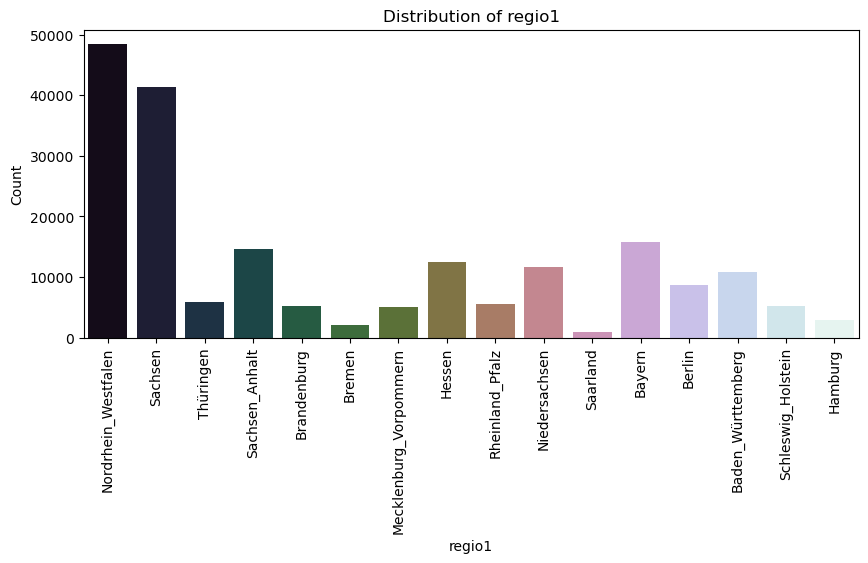

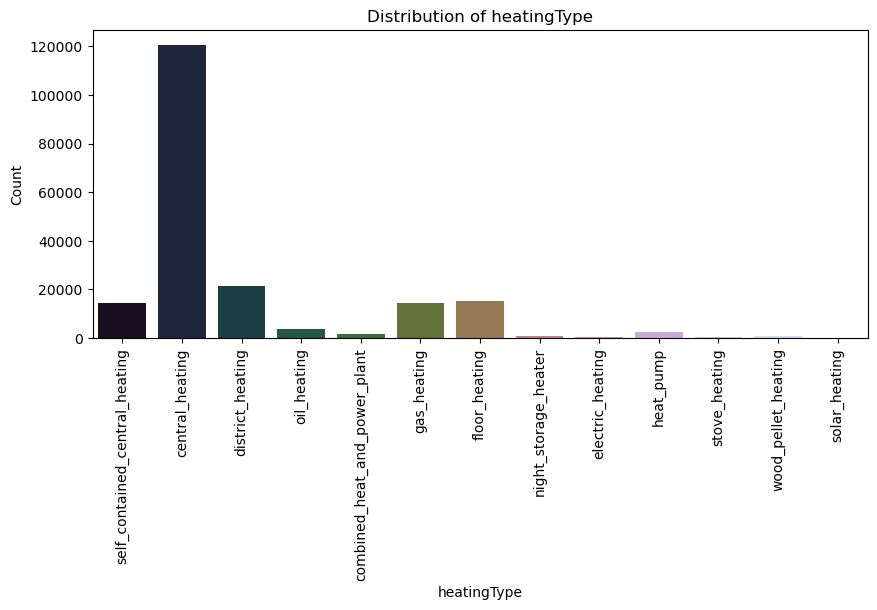

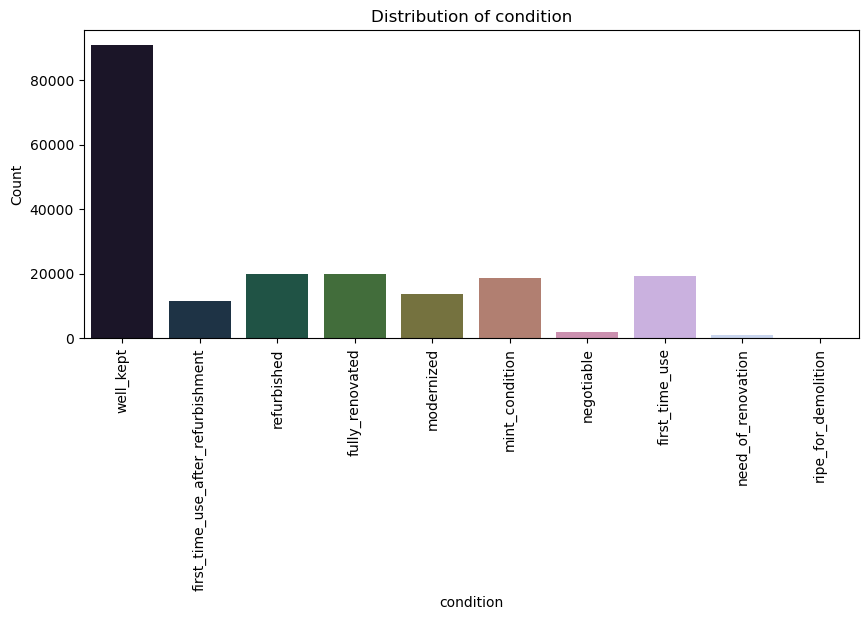

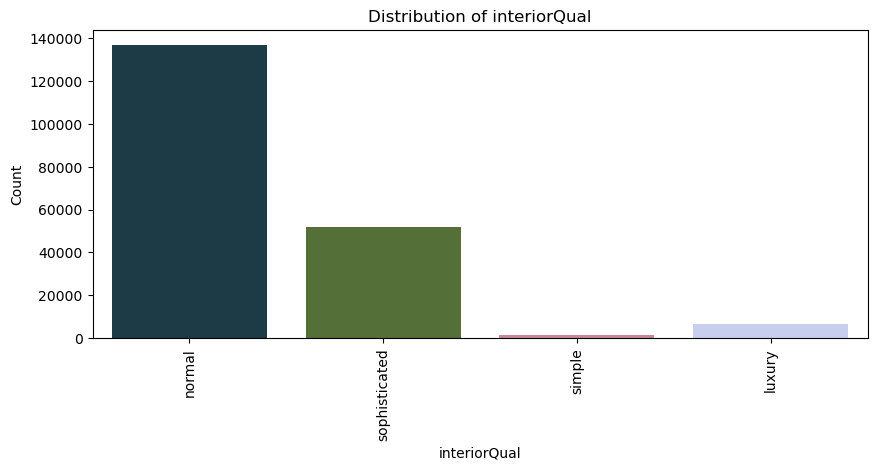

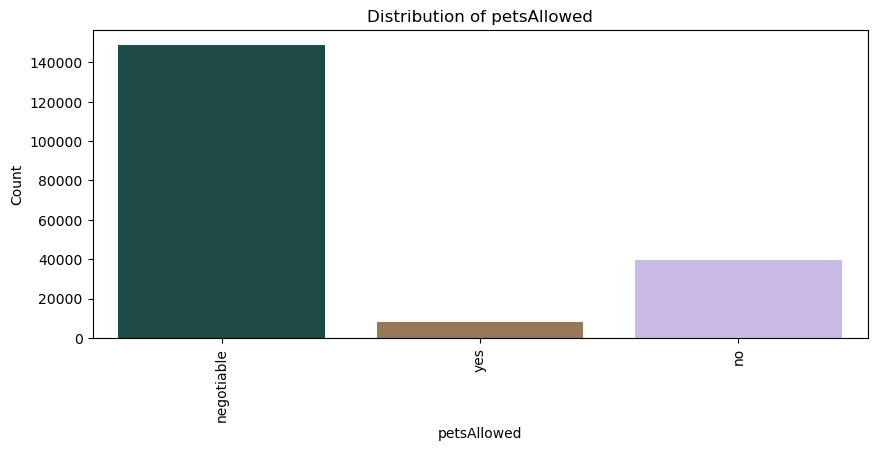

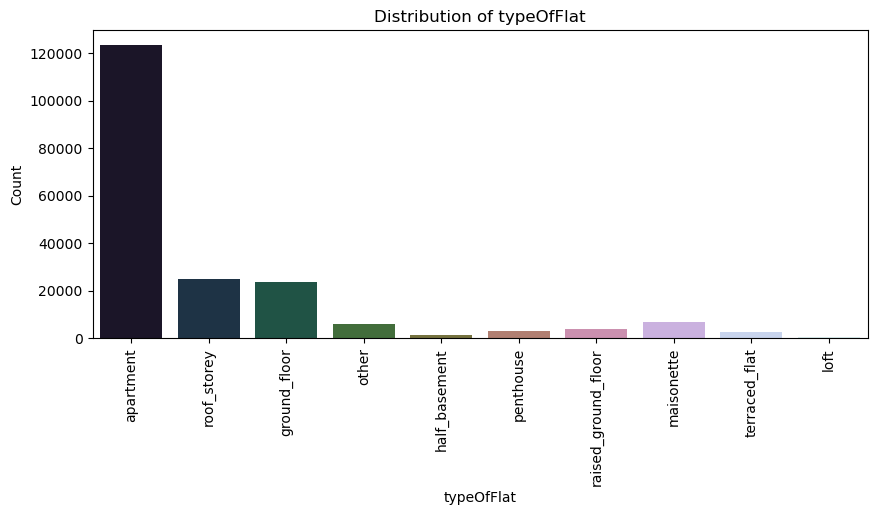

In [18]:
for att in cat_bar:
    plot_count(data, att, 90, (10,4), "cubehelix")

## Distributions by grouping attribute

In [19]:
def plot_hist_grouped(df, cont_att, group_att, size = (10,4), palette = "cubehelix"):
    # only values
    values = df.select(cont_att, group_att).toPandas()
    
    plt.figure(figsize = size)
    sns.kdeplot(data = values, x = cont_att, hue = group_att,\
                 common_norm = False, fill = True, multiple = "stack", palette = palette)
    
    # limit the x axis value in this range (to not take into account very large values)
    plt.xlim(int(min(values[cont_att])), int(0.4*max(values[cont_att])))
    
    plt.title(f"Distribution of {cont_att} by {group_att}")
    plt.xlabel(f"{cont_att}")
    plt.ylabel("Frequency")
    plt.show()

In [20]:
# attribute to group on
group_att = "condition"

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


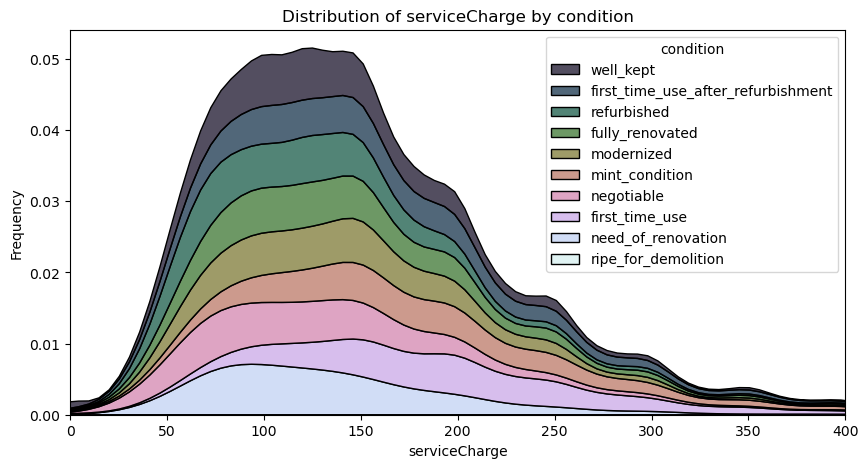

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


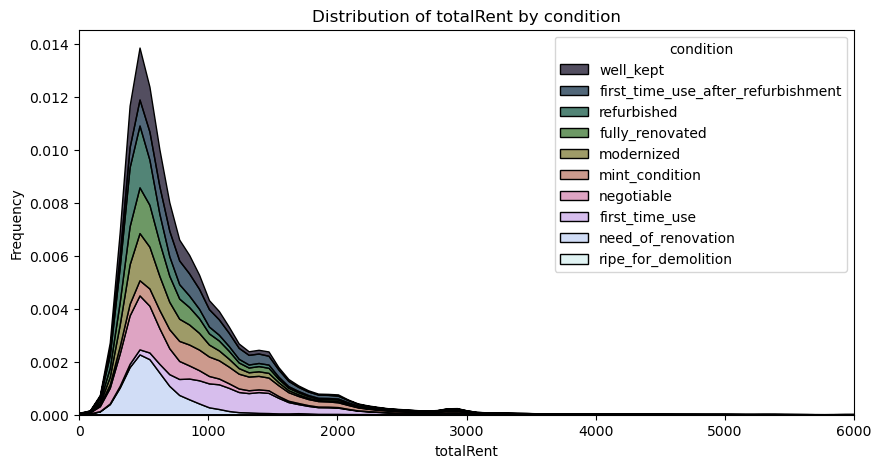

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


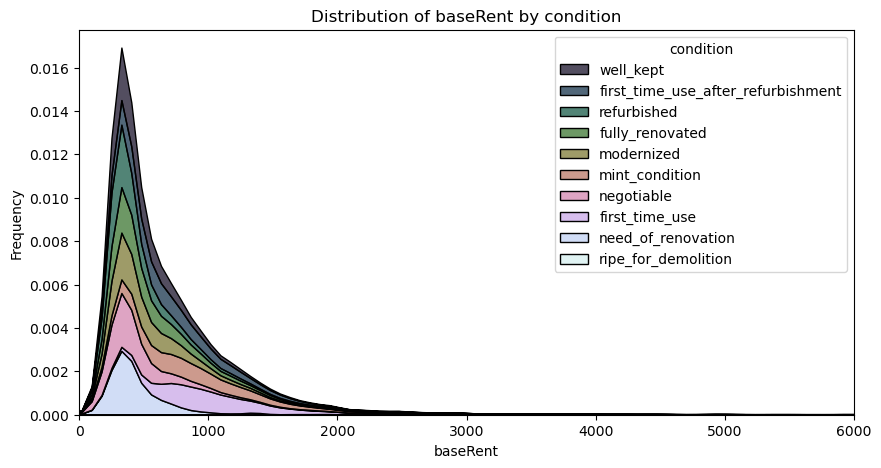

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


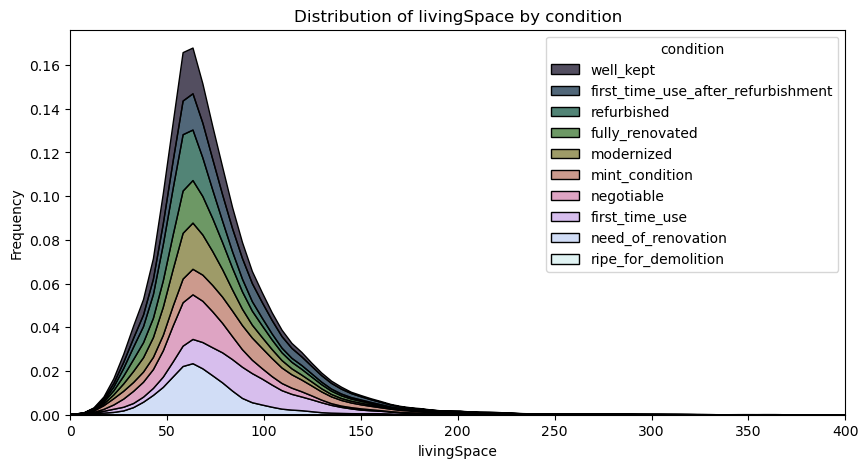

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


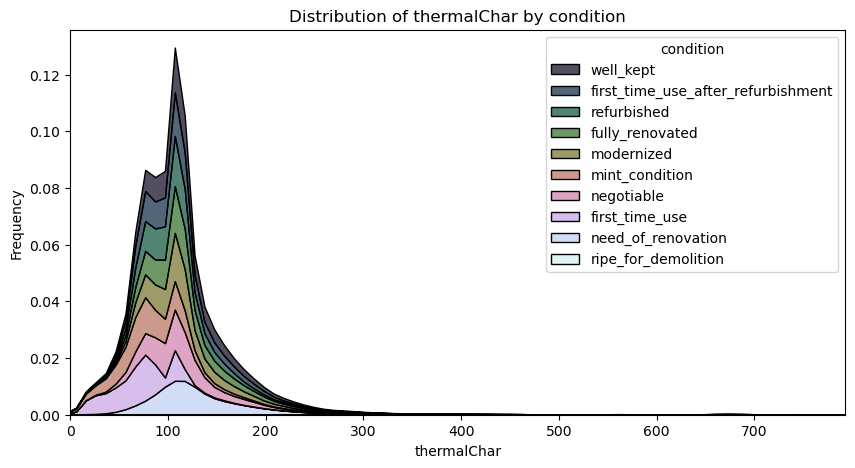

In [21]:
for att in contAtts:
    plot_hist_grouped(data, att, group_att, (10,5))

#### We can do many more groupings on categoricals using the function

## Correlation Analysis

In [22]:
# only numerical attributes
numAtts = (discrAtts + contAtts)
numAtts.remove("geo_plz")

In [23]:
df_corr = data.select(*contAtts)

# assembling the features
features = df_corr.columns
assembler = VectorAssembler(inputCols = features, outputCol = "features")

df_corr_assembled = assembler.transform(df_corr)

#### Pearsons's Correlation

In [24]:
pearson_corr = Correlation.corr(df_corr_assembled, 'features', 'pearson').collect()[0][0]

# DenseMatrix -> numpy array
corr_mat = pearson_corr.toArray()

# numpy array -> pandas dataframe
corr_mat = pd.DataFrame(corr_mat, index = features, columns = features)

##### Heatmap

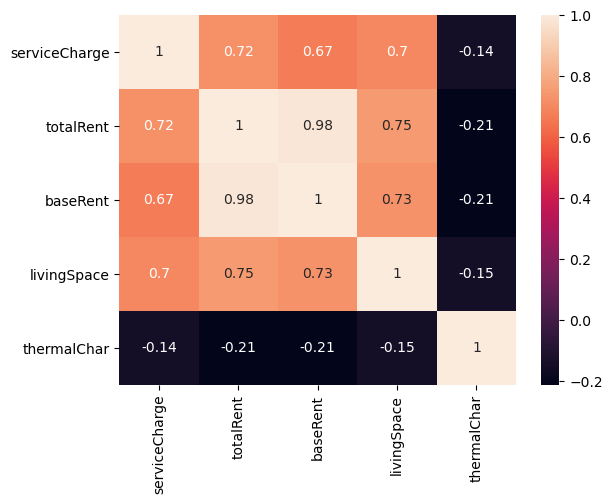

In [25]:
sns.heatmap(corr_mat, annot=True)
plt.show()

#### Spearman's Correlation (only continuous)

In [26]:
df_corr = data.select(*contAtts)

# assembling the features
features = df_corr.columns
assembler = VectorAssembler(inputCols = features, outputCol = "features")

df_corr_assembled = assembler.transform(df_corr)

In [27]:
spear_corr = Correlation.corr(df_corr_assembled, "features", "spearman").collect()[0][0]

# DenseMatrix -> numpy array
corr_mat = spear_corr.toArray()

# numpy array -> pandas dataframe
corr_mat = pd.DataFrame(corr_mat, index = features, columns = features)

23/12/14 20:50:38 WARN Executor: Managed memory leak detected; size = 78754906 bytes, task 0.0 in stage 200.0 (TID 126)
23/12/14 20:50:44 WARN Executor: Managed memory leak detected; size = 78754906 bytes, task 0.0 in stage 206.0 (TID 128)


##### Heatmap

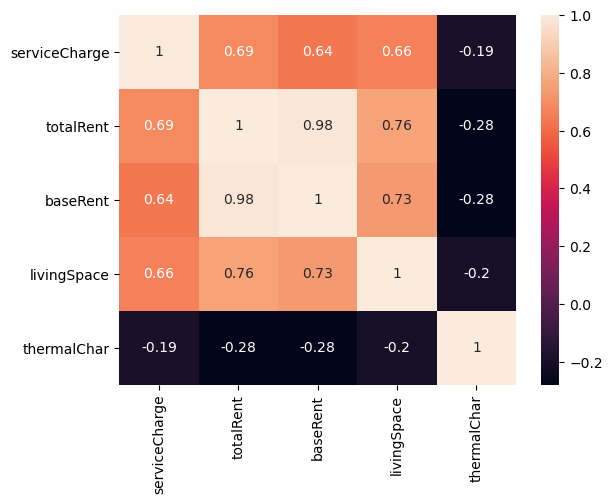

In [28]:
sns.heatmap(corr_mat, annot=True)
plt.show()

#### Spearman's Correlation (with discrete, because they are also ordinal)

In [29]:
df_corr_discr = data.select(*numAtts)

# assembling the features
features_discr = df_corr_discr.columns
assembler = VectorAssembler(inputCols = features_discr, outputCol = "features_discr")

df_corr_discr_assembled = assembler.transform(df_corr_discr)

In [30]:
spear_corr_discr = Correlation.corr(df_corr_discr_assembled, 'features_discr', 'spearman').collect()[0][0]

# DenseMatrix -> numpy array
corr_mat_discr = spear_corr_discr.toArray()

# numpy array -> pandas dataframe
corr_mat_discr = pd.DataFrame(corr_mat_discr, index = features_discr, columns = features_discr)

23/12/14 20:51:17 WARN Executor: Managed memory leak detected; size = 163534214 bytes, task 0.0 in stage 212.0 (TID 132)
23/12/14 20:51:26 WARN Executor: Managed memory leak detected; size = 163534214 bytes, task 0.0 in stage 218.0 (TID 134)


##### Heatmap

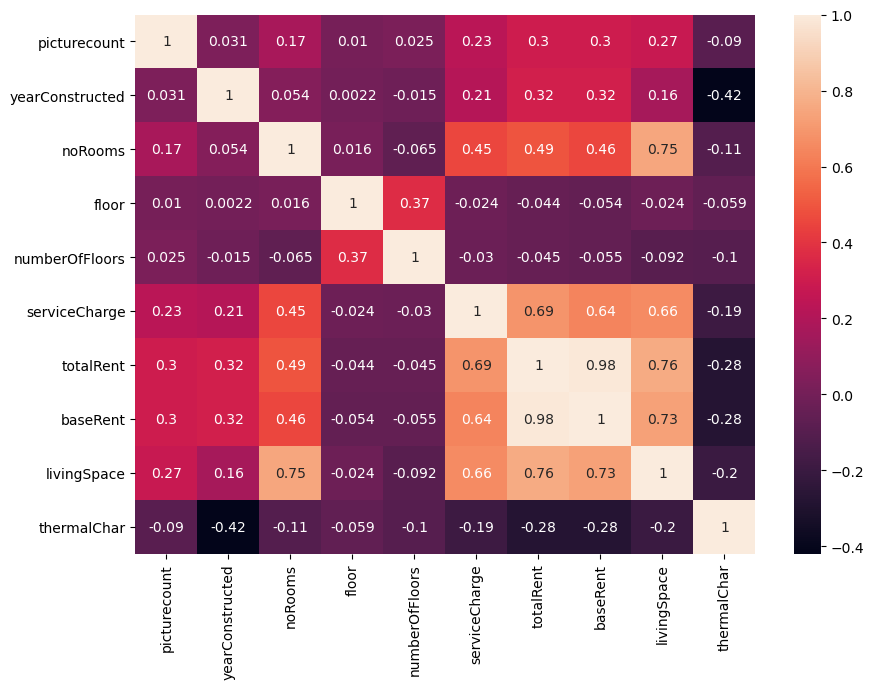

In [31]:
plt.figure(figsize = (10,7))
sns.heatmap(corr_mat_discr, annot=True)
plt.show()

### Scatterplots and Barplots
To check visually linear and non-linear relationships

Using 60% of the data

In [32]:
def plot_scatter(df, att1, att2, group_att = None, size = (10,4), palette = "darkblue"):
    # if i have a grouping-color
    if group_att == None:
        values = df.select(att1, att2).sample(fraction = 0.6, withReplacement = False, seed = 42).toPandas()
    else:
        values = df.select(att1, att2, group_att).sample(fraction = 0.6, withReplacement = False, seed = 42).toPandas()
    
    plt.figure(figsize = size)
    sns.scatterplot(data = values, x = att1,  y = att2, hue = group_att, color = palette)
    
    plt.title(f"Scatterplot of {att2} vs {att1}")
    plt.xlabel(f"{att1}")
    plt.ylabel(f"{att2}")
    plt.show()

In [33]:
def plot_bar_grouped(df, discr_att, cont_att, group_att = None, rot = 0, size = (10,4), palette = "cubehelix"):
    # if i have a grouping-color
    if group_att == None:
        values = df.select(discr_att, cont_att).sample(fraction = 0.6, withReplacement = False, seed = 42).toPandas()
    else:
        values = df.select(discr_att, cont_att, group_att).sample(fraction = 0.6, withReplacement = False, seed = 42).toPandas()
        
    plt.figure(figsize = size)
    ax = sns.barplot(data = values, x = discr_att, y = cont_att, hue = group_att, palette = palette)
    
    plt.title(f"Barplot of {cont_att} vs {discr_att}")
    plt.xlabel(f"{discr_att}")
    plt.ylabel(f"{cont_att}")
    
    # Rotate x-axis tick labels vertically
    ax.set_xticklabels(ax.get_xticklabels(), rotation = rot)
    plt.show()

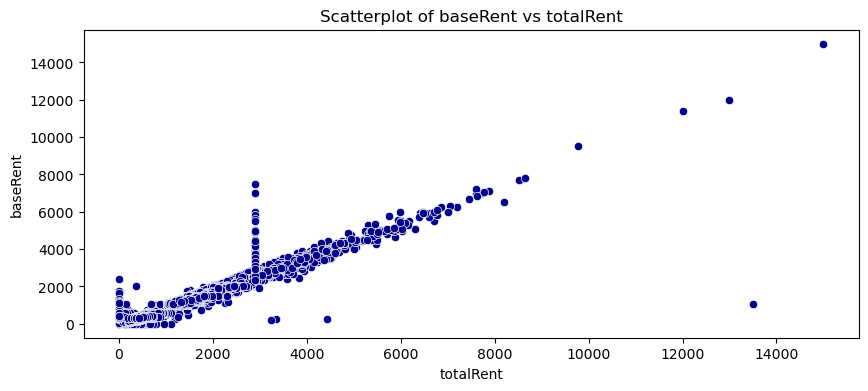

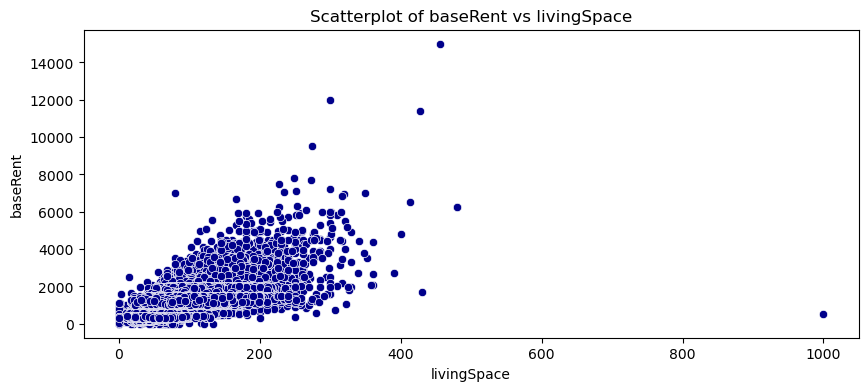

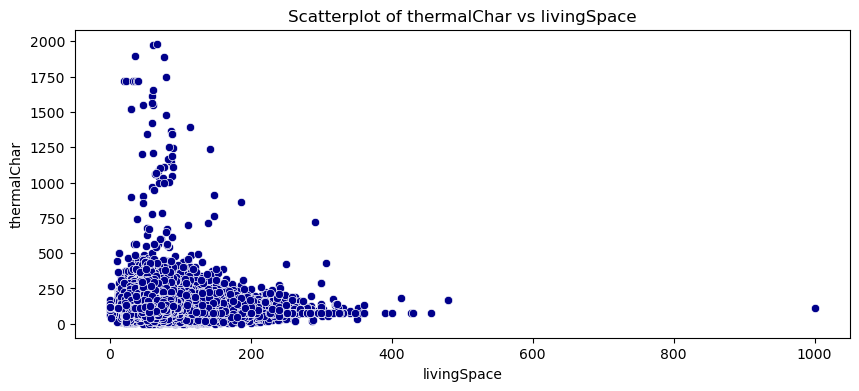

In [34]:
# checking some pairwise correlations between continuous
plot_scatter(data, "totalRent", "baseRent")
plot_scatter(data, "livingSpace", "baseRent")
plot_scatter(data, "livingSpace", "thermalChar")

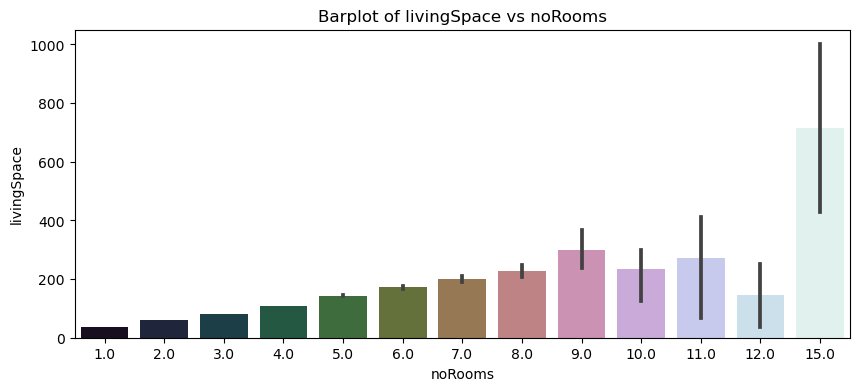

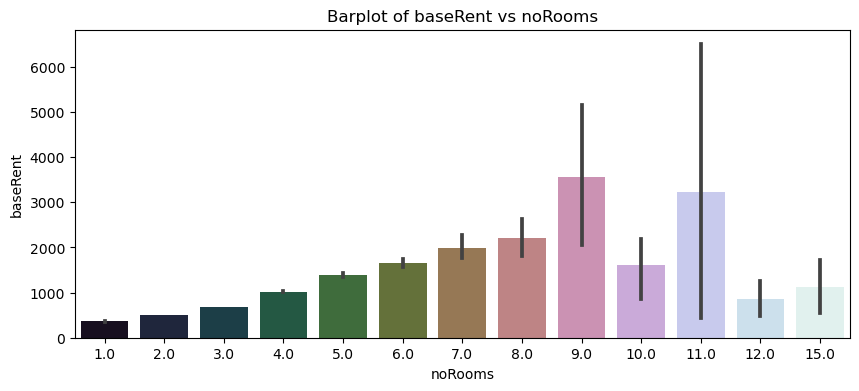

In [35]:
plot_bar_grouped(data, "noRooms", "livingSpace")
plot_bar_grouped(data, "noRooms", "baseRent")

#### Dropping highly correlated features (totalRent)

In [36]:
# dropping totalRent since it's very correlated with baseRent (and this last had no missing values)
df = data.drop("totalRent")

##### Casting geo_plz to string cause it represents a zip code

In [37]:
df = df.withColumn("geo_plz", F.col("geo_plz").cast("string"))

In [38]:
stats = df.select([att for att, t in df.dtypes if t in ["double", "int"]]).describe().toPandas()
stats

23/12/14 20:52:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,picturecount,yearConstructed,noRooms,floor,numberOfFloors,serviceCharge,baseRent,livingSpace,thermalChar
0,count,196440,196440,196440,196440,196440,196440,196440,196440,196440
1,mean,9.9883577682753,1966.4153838322134,2.6437945428629606,2.103364895133374,3.3962482182854816,151.69991936469043,652.0572575341057,73.6061636122979,110.21181317455175
2,stddev,6.369738156418089,45.50310248531476,0.9268421221576835,1.5633904426618508,1.6458517110104782,83.49388977288889,492.74325461473876,31.13872432885168,52.877828522330915
3,min,0,1000,1.0,-1.0,0.0,0.0,0.0,0.0,0.1
4,max,112,2090,15.0,26.0,30.0,1000.0,15000.0,1000.0,1983.0


In [39]:
# instanciating sql context for future queries
sqlCtx = SQLContext(ss)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Outlier Detection

In [40]:
#the following function inserts an additional column into the df and 
def outliers(df,low_perc,high_perc):
    #get numeric
    num_cols = [c[0] for c in df.dtypes if c[1] in ('integer','double')] #('col_name','type')

    #looping 
    for c in num_cols:
        
        #4 cols for each column name (c in cols)
        less_Q1 = 'less_Q1_{}'.format(c)
        more_Q3 = 'more_Q3_{}'.format(c)
        Q1 = 'Q1_{}'.format(c)
        Q3 = 'Q3_{}'.format(c)

        #returns Quantile Floor and Ceil
        Q1 = df.approxQuantile(c,[low_perc], relativeError=0) 
        Q3 = df.approxQuantile(c,[high_perc], relativeError=0)
        
        #Interquantile
        IQR = Q3[0] - Q1[0]
        
        #lower and upper bounds
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        OutCol= 'is_outlier_{}'.format(c) #adding the column
        
        #OutCol(or better:is_outlier column, return 1 or 0)
        df = df.withColumn(OutCol,F.when((df[c] > more_Q3) | (df[c] < less_Q1), 1).otherwise(0))
    
    #count all the is_outliers lines
    sel_col = [c for c in df.columns if c.startswith("is_outlier")]
    
    #sum rows
    df = df.withColumn('total_outliers',sum(df[c] for c in sel_col))

    #dropping the is_outlier columns
    df = df.drop(*[c for c in df.columns if c.startswith("is_outlier")])
    
    #df size
    print (f"size: {df.count(), len(df.columns)}")
    return df

In [45]:
data_out = outliers(df,0.25,0.75)

size: (196440, 28)


In [48]:
data_out.select("total_Outliers").orderBy("total_Outliers", ascending = False).limit(5).show()

+--------------+
|total_Outliers|
+--------------+
|             7|
|             6|
|             6|
|             6|
|             6|
+--------------+



In [49]:
#Returns a Dataframe excluding rows with a certain threshold of outliers
def outliers_threshold(df, val):
    data = df.filter(df['total_Outliers'] <= val)
    #data= data.select(*data.columns)
    return data

In [50]:
data_clean = outliers_threshold(data_out, 2)
print(f"Size of the data without outliers: {data_clean.count(), len(data_clean.columns)}")

Size of the data without outliers: (191375, 28)


In [52]:
# dropping the temporary column
data_clean = data_clean.drop("total_outliers")

# Data Transformation

### Features Scaling

In [66]:
# numeric columns to scale
columns_to_scale = [c[0] for c in data_clean.dtypes if c[1] in ('int','double')] 

# instanciating the VectorAssembler
assembler = VectorAssembler(inputCols = columns_to_scale, outputCol = "scaled_features")
assembled_df = assembler.transform(data_clean)

# apply the MinMaxScaler
scaler = MinMaxScaler(inputCol = "scaled_features", outputCol = "scaled_result")
scaler_model = scaler.fit(assembled_df)
data_scaled = scaler_model.transform(assembled_df)

# extract values from a vector for each column, have to use ArrayType
extract_value = F.udf(lambda vector: vector.toArray().tolist(), returnType = ArrayType(DoubleType()))

# extract scaled values and substitute them into the original columns
data_scaled = data_scaled.withColumn("scaled_values", extract_value(F.col("scaled_result")))
for i, col_name in enumerate(columns_to_scale):
    data_scaled = data_scaled.withColumn(col_name, F.col("scaled_values")[i])

# drop the intermediate attributes
data_scaled = data_scaled.drop("scaled_features", "scaled_result", "scaled_values")

In [68]:
# Show the resulting DataFrame
data_scaled.select(columns_to_scale).limit(5).toPandas().head()

,picturecount,yearConstructed,noRooms,floor,numberOfFloors,serviceCharge,baseRent,livingSpace,thermalChar
0,0.062500,0.874312,0.142857,0.111111,0.166667,0.09500,0.037500,0.06000,0.104695
1,0.098214,0.853211,0.071429,0.148148,0.100000,0.08800,0.027375,0.04020,0.061980
2,0.044643,0.908257,0.000000,0.185185,0.166667,0.08000,0.027500,0.03663,0.039790
3,0.107143,0.822936,0.071429,0.148148,0.100000,0.05000,0.025000,0.05000,0.129810
4,0.125000,0.896330,0.142857,0.259259,0.100000,0.14732,0.037538,0.05666,0.042831


In [69]:
print(f"Size of the scaled dataframe: {data_scaled.count(), len(data_scaled.columns)}")

Size of the scaled dataframe: (191375, 27)


#### Scaled numerical variables' distribution

In [71]:
# splitting attributes based on the type
textAtts, discrAtts, contAtts, catAtts, boolAtts = atts_by_type(data_scaled)

Free text attributes:
['description', 'facilities']

Discrete attributes:
['noRooms', 'floor', 'numberOfFloors']

Continuous attributes:
['picturecount', 'yearConstructed', 'serviceCharge', 'baseRent', 'livingSpace', 'thermalChar']

Categorical attributes:
['regio1', 'heatingType', 'firingTypes', 'condition', 'interiorQual', 'petsAllowed', 'streetPlain', 'typeOfFlat', 'geo_plz', 'regio2', 'regio3']

Boolean attributes:
['balcony', 'hasKitchen', 'cellar', 'lift', 'garden']



In [72]:
atts_hist = contAtts + ["yearConstructed", "picturecount"]
discr_bar = [att for att in discrAtts if att not in atts_hist + ["geo_plz"]]
bool_bar = boolAtts[:]
# find catAtts with uniques <= 20
cat_bar = [att for att in catAtts if data_scaled.select(att).distinct().count() <= 20]

print(f"Distributions to plot with Histograms:\n{atts_hist}\n")
print(f"Distributions to plot with Barplots:\n{discr_bar + bool_bar + cat_bar}")

Distributions to plot with Histograms:
['picturecount', 'yearConstructed', 'serviceCharge', 'baseRent', 'livingSpace', 'thermalChar', 'yearConstructed', 'picturecount']

Distributions to plot with Barplots:
['noRooms', 'floor', 'numberOfFloors', 'balcony', 'hasKitchen', 'cellar', 'lift', 'garden', 'regio1', 'heatingType', 'condition', 'interiorQual', 'petsAllowed', 'typeOfFlat']


##### Continuous

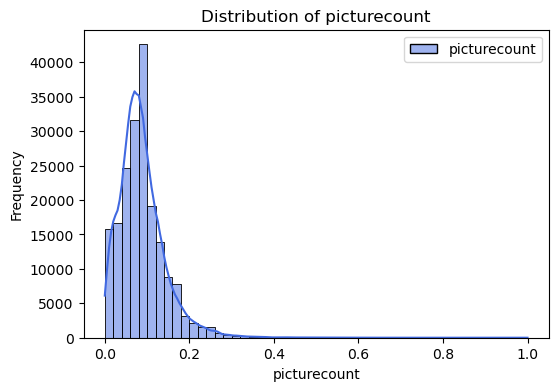

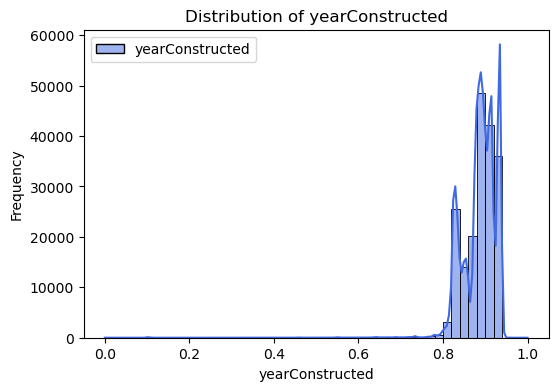

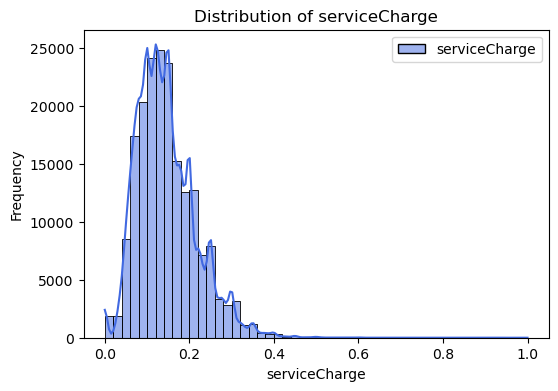

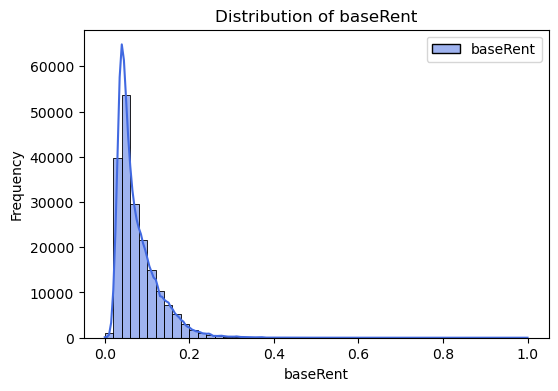

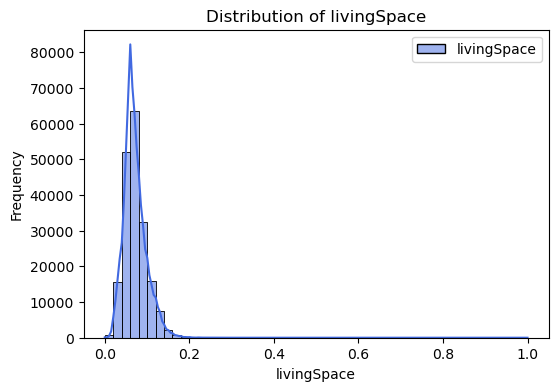

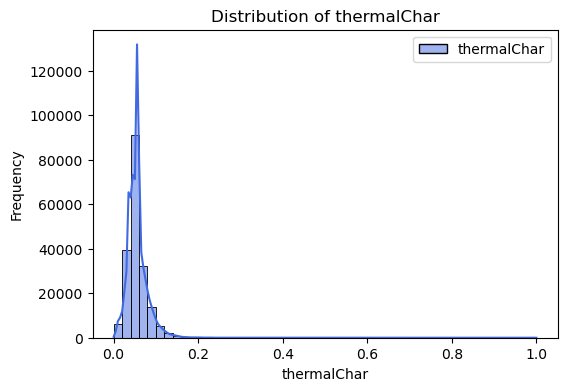

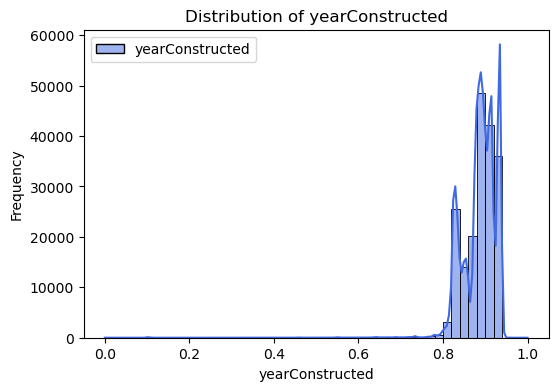

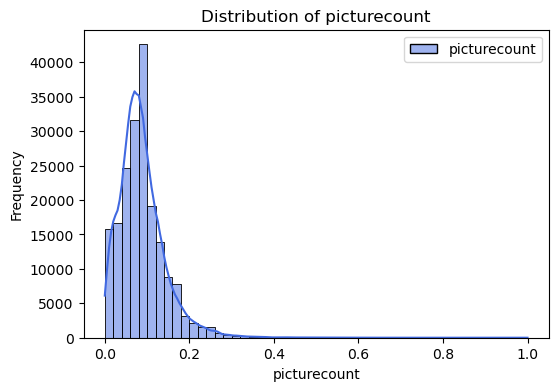

In [73]:
for att in atts_hist:
    plot_hist(data_scaled, att, (6,4), 50, "royalblue")

##### Discrete

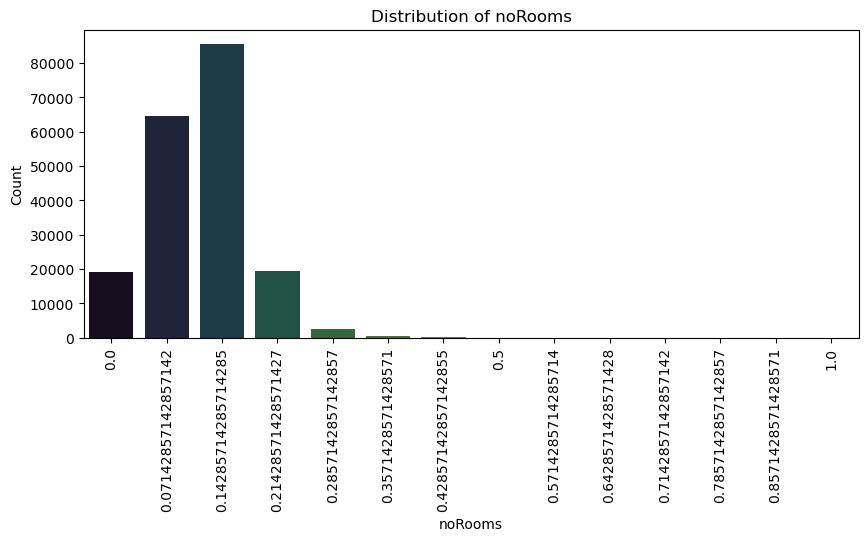

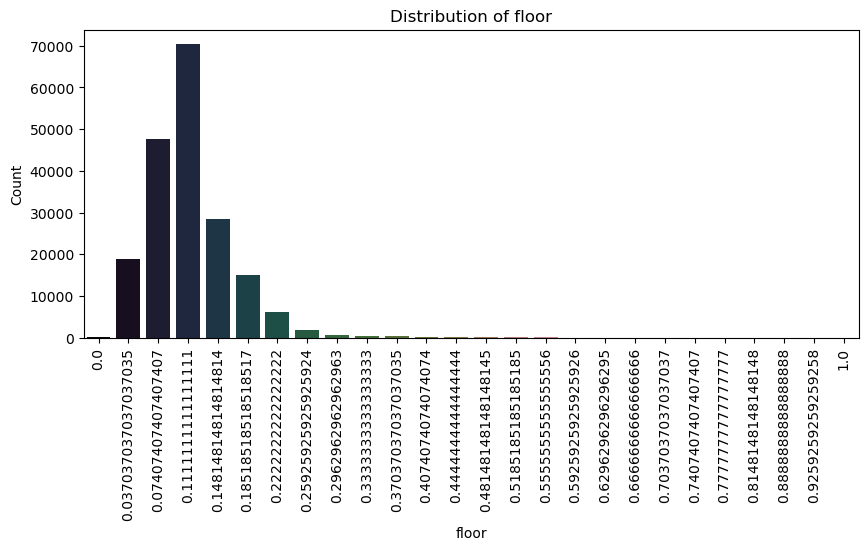

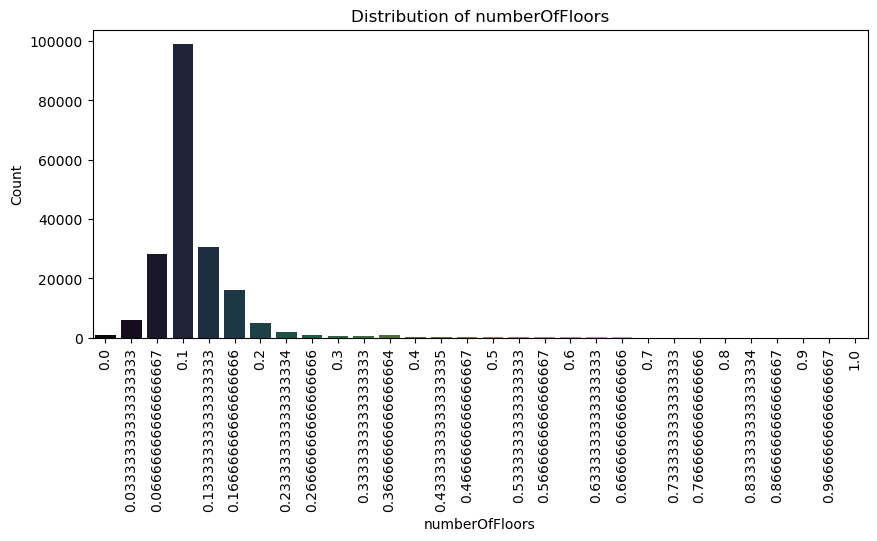

In [74]:
for att in discr_bar:
    plot_count(data_scaled, att, 90, (10,4), "cubehelix")

### Logarithmic Transformation
To remove skewness from variables

#### Skewness computation

In [77]:
# scaled numeric columns
scaled_numCols = [c[0] for c in data_scaled.dtypes if c[1] in ('int','double')]
print(f"Scaled numeric columns:\n{scaled_numCols}")

Scaled numeric columns:
['picturecount', 'yearConstructed', 'noRooms', 'floor', 'numberOfFloors', 'serviceCharge', 'baseRent', 'livingSpace', 'thermalChar']


In [79]:
for col in scaled_numCols:
    # calculate skewness for the specified column
    skewness_value = data_scaled.select(F.skewness(col)).first()[0]
    print(f"Skewness of '{col}': {skewness_value}")

Skewness of 'picturecount': 1.7034634714891201


Skewness of 'yearConstructed': -3.958452498791706


Skewness of 'noRooms': 0.27943459701309753


Skewness of 'floor': 2.2235436722695066


Skewness of 'numberOfFloors': 3.7756313013637643


Skewness of 'serviceCharge': 1.036404166448511


Skewness of 'baseRent': 2.0188803567939244


Skewness of 'livingSpace': 1.1649494765872523


Skewness of 'thermalChar': 7.362407206134611


##### As we imagined, the variables are really skewed. Let's transform them.

In [87]:
data_transformed = data_scaled.select("*")

# iterate through columns and apply log transformation, appending to transformed_df
for att in scaled_numCols:
    log_att = "log_" + att
    data_transformed = data_transformed.withColumn(log_att, F.log(F.col(att) + 1))

# show one adjusted column
data_transformed.select(scaled_numCols[5], ("log_" + scaled_numCols[5])).limit(5).show()

+-------------+-------------------+
|serviceCharge|  log_serviceCharge|
+-------------+-------------------+
|        0.095|0.09075436326846412|
|        0.088|0.08434114843375096|
|         0.08| 0.0769610411361284|
|         0.05|0.04879016416943205|
|      0.14732| 0.1374287879032181|
+-------------+-------------------+



#### Plotting the non-skewed attributes' distribution 

In [92]:
skewless_numCols = [att for att in data_transformed.columns if "log_" in att]
print(skewless_numCols)

['log_picturecount', 'log_yearConstructed', 'log_noRooms', 'log_floor', 'log_numberOfFloors', 'log_serviceCharge', 'log_baseRent', 'log_livingSpace', 'log_thermalChar']


In [96]:
atts_hist = ['log_serviceCharge', 'log_baseRent', 'log_livingSpace', 'log_thermalChar','log_picturecount', 'log_yearConstructed']
discr_bar = ['log_noRooms', 'log_floor', 'log_numberOfFloors']

##### Continuous

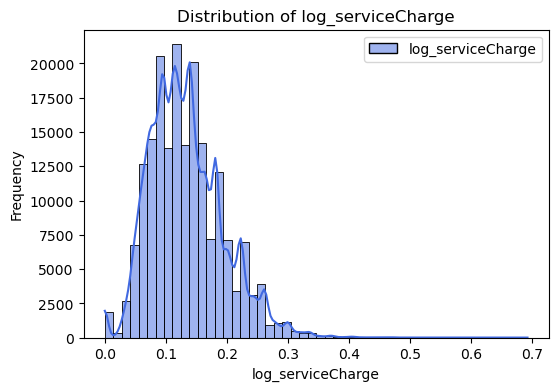

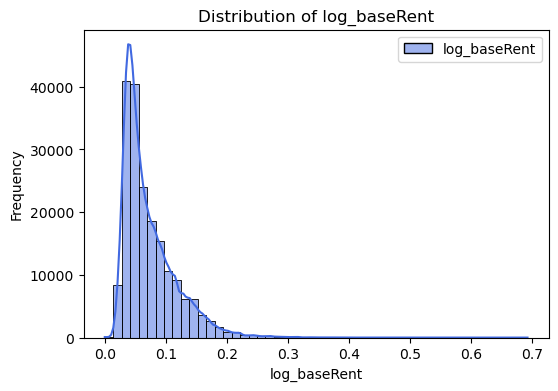

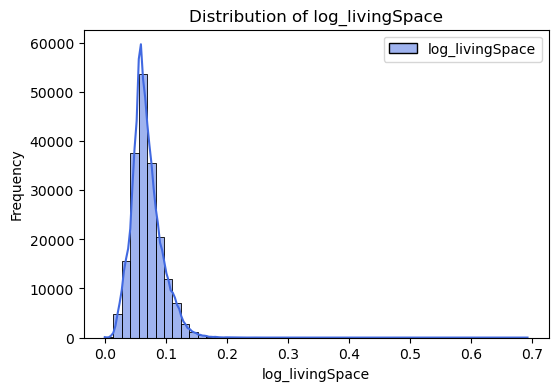

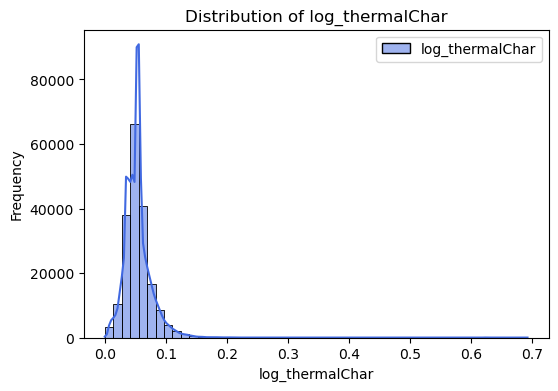

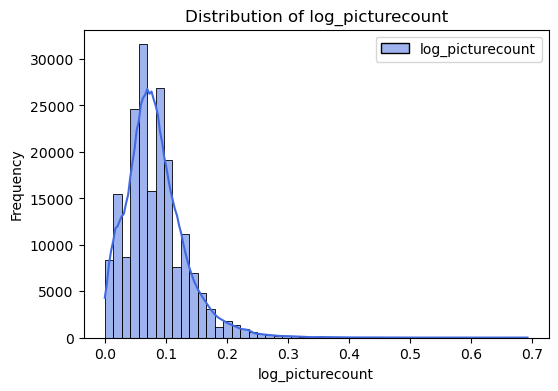

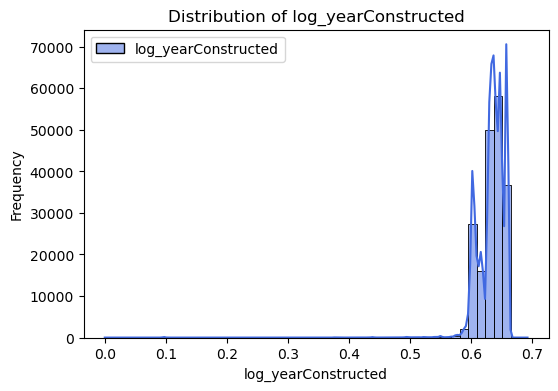

In [97]:
for att in atts_hist:
    plot_hist(data_transformed, att, (6,4), 50, "royalblue")

##### Discrete

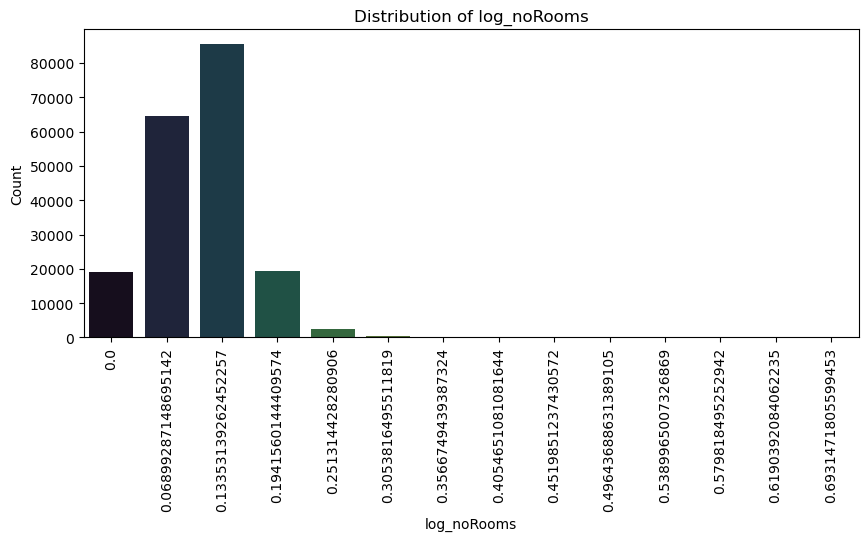

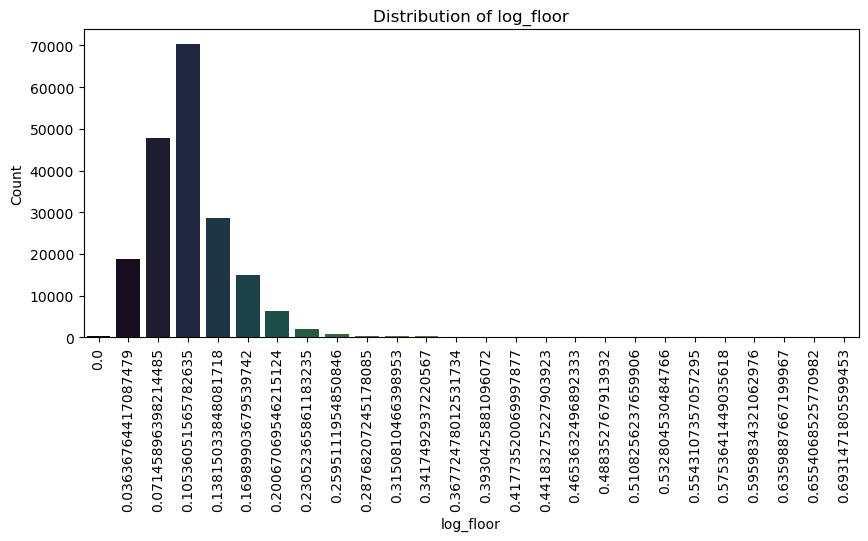

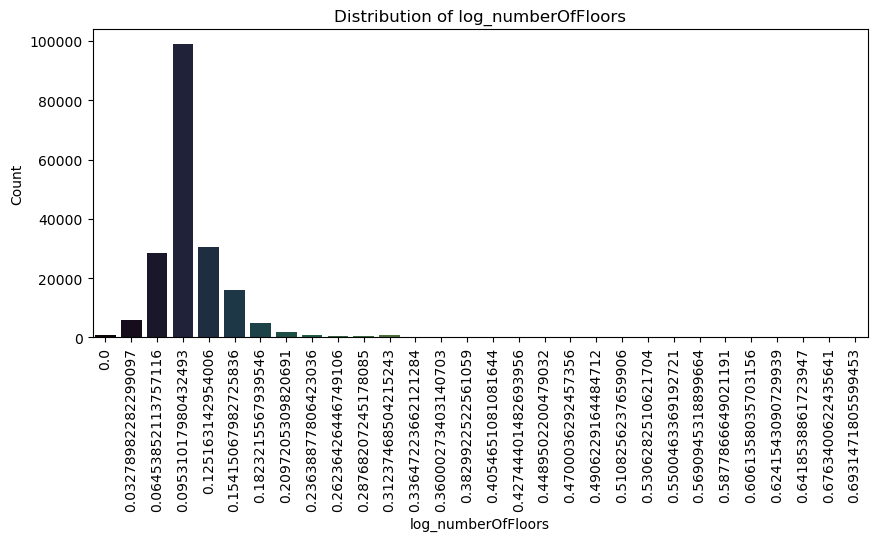

In [98]:
for att in discr_bar:
    plot_count(data_transformed, att, 90, (10,4), "cubehelix")

#### Dropping original columns

In [102]:
original_cols = ['picturecount', 'yearConstructed', 'noRooms', 'floor', 'numberOfFloors', 'serviceCharge', 'totalRent', 'baseRent', 'livingSpace', 'thermalChar']
data_transformed = data_transformed.drop(*original_cols)

print(f"Final attributes:\n{data_transformed.columns}\n")
print(f"Size of the dataframe: {data_transformed.count(), len(data_transformed.columns)}")

Final attributes:
['regio1', 'heatingType', 'balcony', 'firingTypes', 'hasKitchen', 'cellar', 'condition', 'interiorQual', 'petsAllowed', 'streetPlain', 'lift', 'typeOfFlat', 'geo_plz', 'garden', 'regio2', 'regio3', 'description', 'facilities', 'log_picturecount', 'log_yearConstructed', 'log_noRooms', 'log_floor', 'log_numberOfFloors', 'log_serviceCharge', 'log_baseRent', 'log_livingSpace', 'log_thermalChar']



Size of the dataframe: (191375, 27)


#### Stats for the scaled and transformed numerical columns

In [103]:
# new numerical columns
numerical_columns = [col for col, t in data_transformed.dtypes if t in ('int', 'double')]

# calculating statistics 
stats = data_transformed.select(numerical_columns).describe().toPandas()
stats

,summary,log_picturecount,log_yearConstructed,log_noRooms,log_floor,log_numberOfFloors,log_serviceCharge,log_baseRent,log_livingSpace,log_thermalChar
0,count,191375,191375,191375,191375,191375,191375,191375,191375,191375
1,mean,0.08296845139256294,0.6344364814872892,0.10652400436742475,0.10698749093360473,0.10570971474069761,0.13373011953506603,0.07259316335196238,0.0684123253412899,0.053943456593611924
2,stddev,0.049199023774438994,0.023351728296210694,0.0556542430866593,0.04851043166998957,0.044550197385402536,0.06019633782956961,0.043950780216175045,0.02445268506824501,0.023511823756355202
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,0.6931471805599453,0.6931471805599453,0.6931471805599453,0.6931471805599453,0.6931471805599453,0.6931471805599453,0.6931471805599453,0.6931471805599453,0.6931471805599453


## Saving the dataframe as CSV

In [104]:
#pandas_df = data_transformed.toPandas()

In [105]:
#pandas_df.to_csv("dataframe_totalCleaned.csv", index = False)